# Exponential

Here we analyse how accurate are the approximate functions for exponential

### Define a benchmark method

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import torch as th
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def benchmark(real_func, approx_func, interval, n_points=100, approx_kwargs={}, forward_transformer=lambda x:x, backward_transformer=lambda x:x):
    """
    Benchmark an approximation function compared to an exact function.
    Compute and print the relative divergence
    
    Args:
        real_func: 
        approx_func: 
        interval: 
        n_points: 
        approx_kwargs: optional kwargs to provide to the approximation function
        forward_transformer: optional input transformation to apply before calling approx_func
        backward_transformer: optional output transformation to apply after calling approx_func
    """
    start, stop = interval
    points = np.linspace(start, stop, num=n_points)
    real_values = []
    approx_values = []
    for x in points:
        x = th.tensor([x])
        real_value = real_func(x)
        real_values.append(real_value.item())
        x_syft = forward_transformer(x)
        approx_value_syft = approx_func(x_syft, **approx_kwargs)
        approx_value = backward_transformer(approx_value_syft)
        approx_values.append(approx_value.item())
        
    plt.figure(figsize=(15,4))
    plt.subplot(121, title="Real and approximate logarithm")
    real_values = np.array(real_values)
    approx_values = np.array(approx_values)
    plt.plot(points, real_values)
    plt.plot(points, approx_values)
    
    plt.subplot(122, title="Relative error")
    norm_diff = 2 * np.abs(real_values - approx_values)/np.abs(real_values + approx_values)
    plt.plot(points, norm_diff)

    plt.show()

## 1. Using the limit method

In [4]:
from funcs import exp_limit

## 1.A Approximation alone

We analyse here the loss incurred by the approximation using only normal pytorch tensors

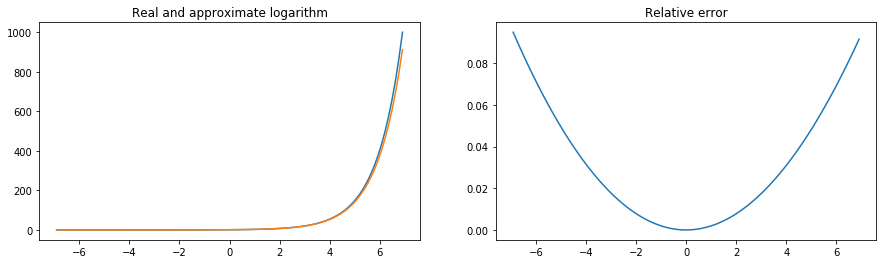

In [5]:
benchmark(
    th.exp, 
    exp_limit, 
    interval = (-np.log(1000), np.log(1000)), 
    approx_kwargs={'iterations': 8}
)

With this approximation, and for the range of value considered, we stay behind the 1% error rate, which is completely fine for ML.

## 1.B Approximation with AdditiveSharingTensors

In [6]:
import syft as sy
hook = sy.TorchHook(th)

bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
charlie = sy.VirtualWorker(hook, id="charlie")
crypto = sy.VirtualWorker(hook, id="crypto_provider")

Note that we need to put the precision higher for the fixed precision encoding using `precision_fractional=5`. 

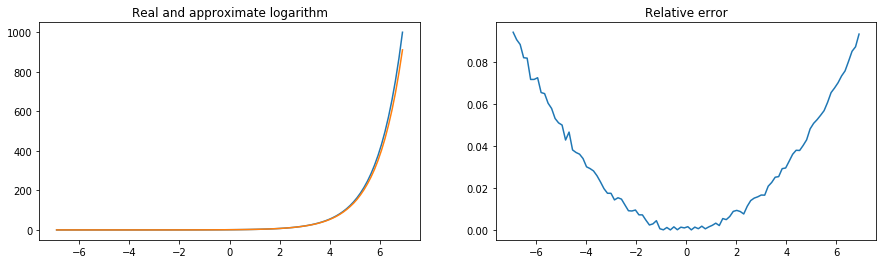

In [7]:
benchmark(
    th.exp, 
    exp_limit, 
    interval = (-np.log(1000), np.log(1000)), 
    approx_kwargs={'iterations': 8},
    forward_transformer=lambda x: x.fix_precision(precision_fractional=5).share(alice, bob, crypto_provider=crypto),
    backward_transformer=lambda x: x.get().float_precision()
)

This result is really close to the expected approximation using MPC!